In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tf_clahe
IMG_H = 128
IMG_W = 128
IMG_C = 3  ## Change this to 1 for grayscale.

In [8]:
def bcet(img):

    
    Lmin = tf.reduce_min(img) # MINIMUM OF INPUT IMAGE
#     Lmin = np.min(img) # MINIMUM OF INPUT IMAGE
#     print("Lmin", Lmin)
    Lmax = tf.reduce_max(img) # MAXIMUM OF INPUT IMAGE
#     Lmax = np.max(img) # MAXIMUM OF INPUT IMAGE
#     print("Lmax", Lmax)
    Lmean = tf.reduce_mean(img) #MEAN OF INPUT IMAGE
#     Lmean = np.mean(img) #MEAN OF INPUT IMAGE
#     print("Lmean", Lmean)
    LMssum = tf.reduce_mean(img * img) #MEAN SQUARE SUM OF INPUT IMAGE
#     LMssum = np.mean(pow(img, 2)) #MEAN SQUARE SUM OF INPUT IMAGE
#     print("LMssum", LMssum)

    Gmin = tf.constant(0, dtype="float32") #MINIMUM OF OUTPUT IMAGE
    Gmax = tf.constant(255, dtype="float32") #MAXIMUM OF OUTPUT IMAGE
    Gmean = tf.constant(85, dtype="float32") #MEAN OF OUTPUT IMAGE
    
    subber = tf.constant(2, dtype="float32")

    bnum = Lmax * Lmax *(Gmean-Gmin) - LMssum*(Gmax-Gmin) + Lmin * Lmin *(Gmax-Gmean)
    bden = subber*(Lmax*(Gmean-Gmin)-Lmean*(Gmax-Gmin)+Lmin*(Gmax-Gmean))

    b = bnum/bden

    a = (Gmax-Gmin)/((Lmax-Lmin)*(Lmax+Lmin-subber*b))

    c = Gmin - a*(Lmin-b) * (Lmin-b)

    y = a * (img-b) * (img-b) + c #PARABOLIC FUNCTION

    return y

In [9]:
def bcet_processing(img,channels=3):
#     img = tf.make_tensor_proto(img,dtype="int64")
#     img = tf.make_ndarray(img)
#     print(img.shape)
    layers = []
    for i in range(channels):
        layer = img[:,:,i]
        layer = bcet(layer)
        layers.append(layer)
        
# #     print(red.shape)
#     blue = img[:,:,1]
# #     print(blue.shape)
#     green = img[:,:,2]
#     red = img[:,:,0]
# #     print(red.shape)
#     blue = img[:,:,1]
# #     print(blue.shape)
#     green = img[:,:,2]
# #     print(green.shape)
    
#     red = bcet(red)
# #     print(red.shape)
#     blue = bcet(blue)
# #     print(blue.shape)
#     green = bcet(green)
# #     print(green.shape)
    
#     final_image = np.stack((red, blue, green), axis=-1)
#     final_image = tf.convert_to_tensor(final_image, dtype=tf.int64) 
#     print(final_image.shape)
    final_image = tf.stack(layers, axis=-1)
#     print(final_image.shape)
    return final_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

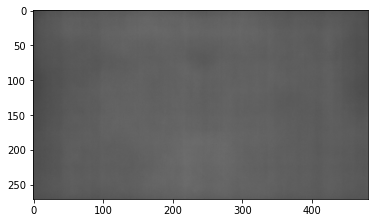

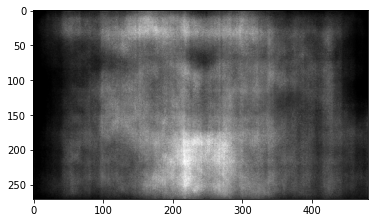

<Figure size 432x288 with 0 Axes>

In [14]:

# filename = "mura_data/RGB/test_data/defect/defect.bmp"
# filename = "mura_data/RGB/test_data/normal/normal.bmp"

filename = "mura_data/Grayscale/test_data/defect/defect.bmp"
# filename = "mura_data/Grayscale/test_data/normal/normal.bmp"

img = tf.io.read_file(filename)
img = tf.io.decode_bmp(img, channels=3)
# print(tf.rank(img))
img = tf.cast(img, tf.float32)



normal = tf.cast(img, tf.int64)
plt.imshow(normal)
plt.figure()


img = bcet_processing(img)
# img = tf_clahe.clahe(img)
img = tf.cast(img, tf.int64)

plt.imshow(img)
plt.figure()